# Getting started with the Tuna backends

**Author:** Marios Samiotis (m.samiotis@tudelft.nl)

**Date:** December 19, 2025

# 1. Introduction

In this notebook we will get started with using the Tuna superconducting quantum backends which exist at the [Quantum Inspire 2.0](https://www.quantum-inspire.com/) cloud services!

Prior to using this notebook, for optimal performance, make sure that you are running it within a customized Python 3.12 environment which includes the packages "quantuminspire" and "qiskit-quantuminspire".

For details on how to create such a Python environment, follow the installation instructions in the [README file](https://github.com/DiCarloLab-Delft/QuantumInspireUtilities/blob/main/README.md).

Useful links:
1. [Tuna Backends Operational Specifics](https://www.quantum-inspire.com/kbase/tuna-5-operational-specifics/)
2. [Backend Performance Dashboards](https://monitoring.qutech.support/public-dashboards/c494a21fb6b7405f850ab8f340f798ef?orgId=1&refresh=10s) [live updates]
3. [Join our Slack community!](https://join.slack.com/t/qisuperconducting/shared_invite/zt-35o7zitdh-_9QPmB53hhLy12Eat5gwWA)

First, we run the following cell in order to login to the Quantum Inspire platform. You need an account in order to login to the platform.

Please click on "Confirm" in the pop-up browser window to login.

In [1]:
# ! qi login "https://api.quantum-inspire.com"

! qi login "https://staging.qi2.quantum-inspire.com"

Please continue logging in by opening: https://auth.staging.quantum-inspire.com/activate?user_code=SGXJ-GRTB in your browser
If promped to verify a code, please confirm it is as follows: SGXJ-GRTB
Login successful!
Using member ID 31


Run the following cell for all necessary library imports,

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from qiskit import QuantumCircuit, transpile
from qiskit_quantuminspire.qi_provider import QIProvider
from qi_utilities.utility_functions.circuit_modifiers import apply_readout_circuit
from qi_utilities.utility_functions.ro_correction import (split_raw_shots, extract_ro_assignment_matrix, plot_ro_assignment_matrix,
                                                          ro_corrected_multi_qubit_prob)
from qi_utilities.utility_functions.midcircuit_msmt import get_multi_qubit_counts, get_multi_qubit_prob

# 2. Connecting to the backend

We first connect to the Quantum Inspire provider, by running the following cell,

In [3]:
provider = QIProvider()

The following command prints the full list of all available backends of the platform,

In [4]:
provider.backends()

[<qiskit_quantuminspire.qi_backend.QIBackend object at 0x174687d40 (name=Spin-2+, id=1)>,
 <qiskit_quantuminspire.qi_backend.QIBackend object at 0x168713890 (name=Stubbed, id=2)>,
 <qiskit_quantuminspire.qi_backend.QIBackend object at 0x16abc7380 (name=QX emulator, id=3)>,
 <qiskit_quantuminspire.qi_backend.QIBackend object at 0x1075640b0 (name=HectoQubit/2, id=5)>,
 <qiskit_quantuminspire.qi_backend.QIBackend object at 0x172d897c0 (name=Tuna-9, id=9)>]

We now connect to a Tuna backend by running the following cell,

In [5]:
backend_name = "Tuna-9"
backend = provider.get_backend(name=backend_name)

By running the cell below, the connectivity of the processor is shown (otherwise known as "coupling map"),

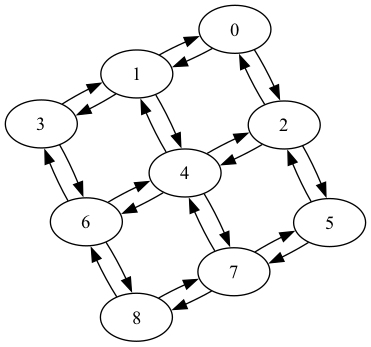

In [6]:
backend.coupling_map.draw()

Any single- or multi-qubit gates that may be applied on the qubits of the Tuna backends are referred to as "instructions". The full list of allowed instructions of the Tuna backend is shown by running the following cell,

In [7]:
backend.instructions

[(Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), (0,)),
 (Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), (1,)),
 (Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), (2,)),
 (Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), (3,)),
 (Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), (4,)),
 (Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), (5,)),
 (Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), (6,)),
 (Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), (7,)),
 (Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), (8,)),
 (Instruction(name='rz', num_qubits=1, num_clbits=0, params=[Parameter(λ)]),
  (0,)),
 (Instruction(name='rz', num_qubits=1, num_clbits=0, params=[Parameter(λ)]),
  (1,)),
 (Instruction(name='rz', num_qubits=1, num_clbits=0, params=[Parameter(λ)]),
  (2,)),
 (Instruction(name='rz', num_qubits=1, num_clbits=0, params=[Parameter(λ)]),
  (3,)),
 (Instruction(nam

When executing a quantum algorithm on any backend, one needs to choose the number of measurement shots to be performed for the given quantum circuit. The maximum number of allowed shots on the Tuna backend can be obtained by running the command

In [8]:
backend.max_shots

16384

# 3. Running your first quantum circuit on a Tuna backend

In this section, we create a quantum circuit which generates an entangled two-qubit quantum state, better known as the [Bell-pair state](https://en.wikipedia.org/wiki/Bell_state).
For more information concerning what a Bell-pair state is, [click here](https://www.quantum-inspire.com/kbase/hello-quantum-world/).

To create a Bell-pair state on a Tuna backend, one needs to apply a two-qubit gate between two qubits that are directly coupled to each other. Such a circuit can be created in two ways: either by taking into consideration the number of qubits and connectivity of the device when writing the code, or by creating a theoretical circuit consisting of two qubits and then using the Qiskit transpiler, which subsequently maps the operations according to the connectivity and qubit number constraints.

In Section 3.1 we create a quantum circuit with a quantum register of size the total number of qubits of the Tuna backend, respecting the connectivity of the device, while in Section 3.2 we use the Qiskit transpiler, and perform post-processing on the measurement outcomes to mitigate readout errors which occur during measurement.

## 3.1. Creating a Bell-pair state without the use of the Qiskit transpiler

Since we are not using the Qiskit transpiler, we have to define a quantum circuit with a number of qubits equal to the total number of qubits of the Tuna backend, as well as perform two-qubit gates on qubits that are coupled together (see the coupling map of the processor above).

In addition, one is advised to consult the appropriate Tuna backend [performance dashboard](https://monitoring.qutech.support/public-dashboards/c494a21fb6b7405f850ab8f340f798ef?orgId=1&refresh=10s) with choosing the most performant two-qubit pair at a given moment in time. At the time of writing this guide, qubits Q0 and Q2 seemed to be the best choice.

In [9]:
qubit_0 = 0 # the entry "0" is for qubit "Q0"
qubit_1 = 2 # the entry "2" is for qubit "Q2"

qc = QuantumCircuit(9, # total number of qubits of the Tuna backend
                    2) # classical bit register size

qc.h(qubit_0)
qc.cx(qubit_0, qubit_1)
qc.measure(qubit_0, cbit=0)
qc.measure(qubit_1, cbit=1)

We may visualize the above quantum circuit by running the following cell,

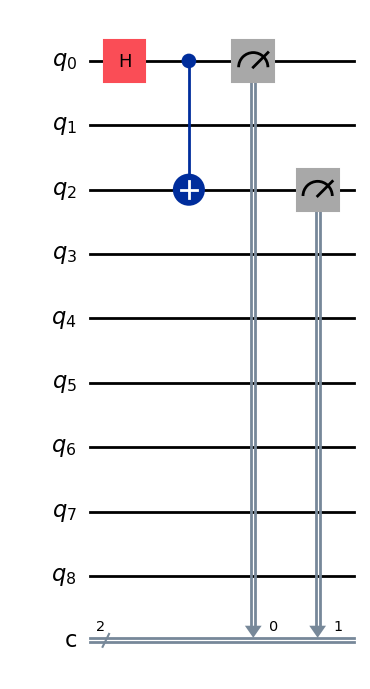

In [10]:
qc.draw('mpl')

Notice the bit-ordering convention being used here. The measurement outcome of qubit qubit_0 (qubit_1) is stored in the least-significant (most-significant) bit cbit_0 (cbit_1) of the classical register.

Now we run the above circuit on the Tuna backend. We choose for the number of circuit shots the maximum allowed, which as we have already seen in Section 2 is given by "backend.max_shots".

Usually for regular-sized jobs and a normal queue, the Bell-state algorithm should take only a few seconds of run time, and the result should be retrieved within a minute. Nevertheless, it is a safe practice to request a timeout of about 10 minutes for an unusually busy queue.

In [11]:
nr_shots = backend.max_shots
job = backend.run(qc, shots=nr_shots)
result = job.result(timeout = 600) # timeout is in units of seconds

We now gather the measurement counts and visualize the results,

In [12]:
counts = result.get_counts()

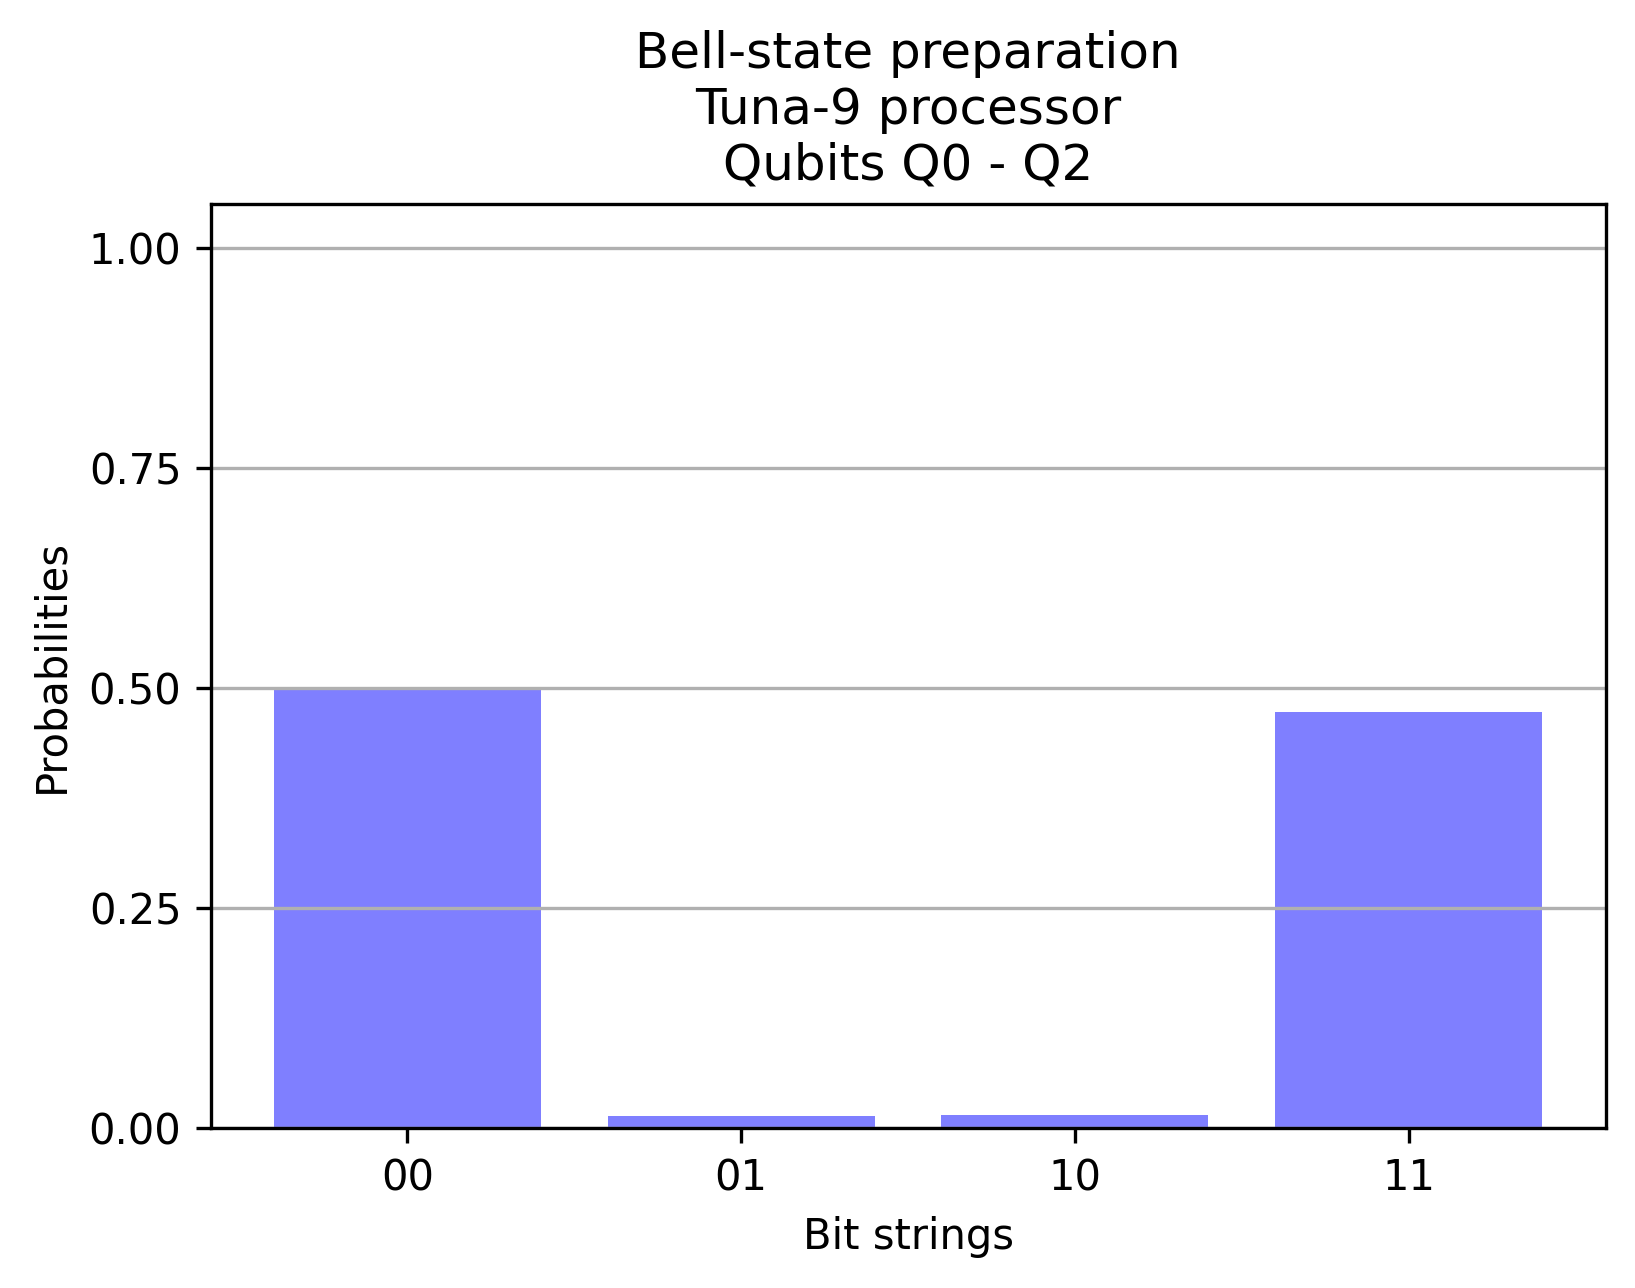

In [13]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

for bit_string in counts:
    ax.bar(bit_string,
           counts[bit_string] / nr_shots,
           color='blue', alpha=0.5)

ax.set_xlabel("Bit strings")
ax.set_ylabel("Probabilities")
ax.set_title(f"Bell-state preparation\n{backend_name} processor\nQubits Q{qubit_0} - Q{qubit_1}")

ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
ax.set_ylim(0.0, 1.05)

plt.grid(axis='y')
plt.show()

## 3.2. Creating a Bell-pair state by using the Qiskit transpiler and applying readout error mitigation (ADVANCED)

In this section, we will be using Qiskit's "transpile" function, which simplifies circuit writing since the user does not need to consider the number of qubits, the coupling map or the allowed set of instructions of the Tuna backends when creating a circuit; the transpiler takes care of all that. Additionally, we will be post-processing the raw data after receiving the job result, in order to mitigate readout errors that occur during the measurement.

In the previous example, the quantum circuit that we created uses a CNOT gate between two qubits. Reading through the Tuna backends [operational specifics](https://www.quantum-inspire.com/kbase/tuna-5-operational-specifics/), one notices that the only native two-qubit gate in the Tuna backends is the CZ gate. How can it be that the CNOT gate was being executed by the Tuna backend in the previous example?

Whenever a user sends a quantum circuit to the Tuna backends which includes a CNOT gate, or any other non-native two-qubit gate, those are being decomposed by the Tuna backend internal compilation software into a combination of single-qubit gates and CZ gates, an internal transpilation step which is not visible to the user.

If the user is concerned with optimizing their circuits so that those do not get further decomposed by the Tuna backend internal compilation software, then they need to define the following basis gates list which correspond to the accurate set of allowed instructions of the device, which is then passed to the Qiskit transpiler manually,

In [14]:
tuna_backends_basis_gates = ['id', 's', 'sdg', 't', 'tdg', 'x', 'rx', 'y', 'ry', 'z', 'rz', 'cz', 'barrier', 'delay', 'reset']

Now let us define once again the Bell-pair state preparation quantum circuit. Using the mid-circuit measurement functionality (more on that in Section 4 of this notebook), we append the necessary measurements, used later for mitigating readout errors, at the end of the original circuit,

In [15]:
# This is a 'theoretical' quantum circuit: the qubit number as well
# as the connectivity of the Tuna backend is being ignored

qubit_0 = 0
qubit_1 = 1

qc = QuantumCircuit(2, 2)

qc.h(qubit_0)
qc.cx(qubit_0, qubit_1)
qc.measure(qubit_0, cbit=0)
qc.measure(qubit_1, cbit=1)

qc = apply_readout_circuit(qc, [qubit_0, qubit_1])

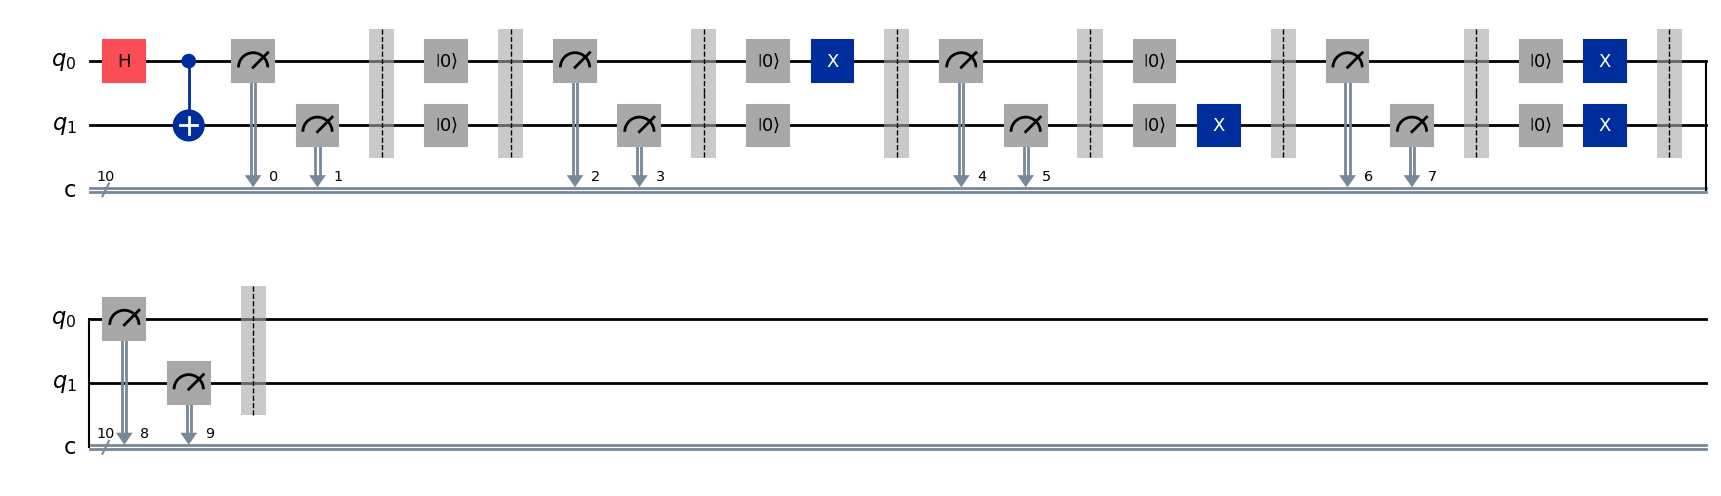

In [16]:
qc.draw('mpl')

In order to run the above circuit on the Tuna backend, it first needs to be transpiled.

But how does the transpiler know which qubit pair to choose? If the user does not specify it, it begins with the first entry of the coupling map of the device.

Nevertheless, the user has the freedom to define a qubit priority list: by consulting the appropriate [performance dashboard](https://monitoring.qutech.support/public-dashboards/c494a21fb6b7405f850ab8f340f798ef?orgId=1&refresh=10s) page of the Tuna backend, one can create a list of qubits whose two-qubit gate performance is the most optimal at the given moment in time.

At the day of writing this guide, the best list was chosen as qubit_list = [0, 2]

In [17]:
qubit_list = [0, 2]

In [18]:
qc_transpiled = transpile(qc, backend, initial_layout=qubit_list, basis_gates=tuna_backends_basis_gates)

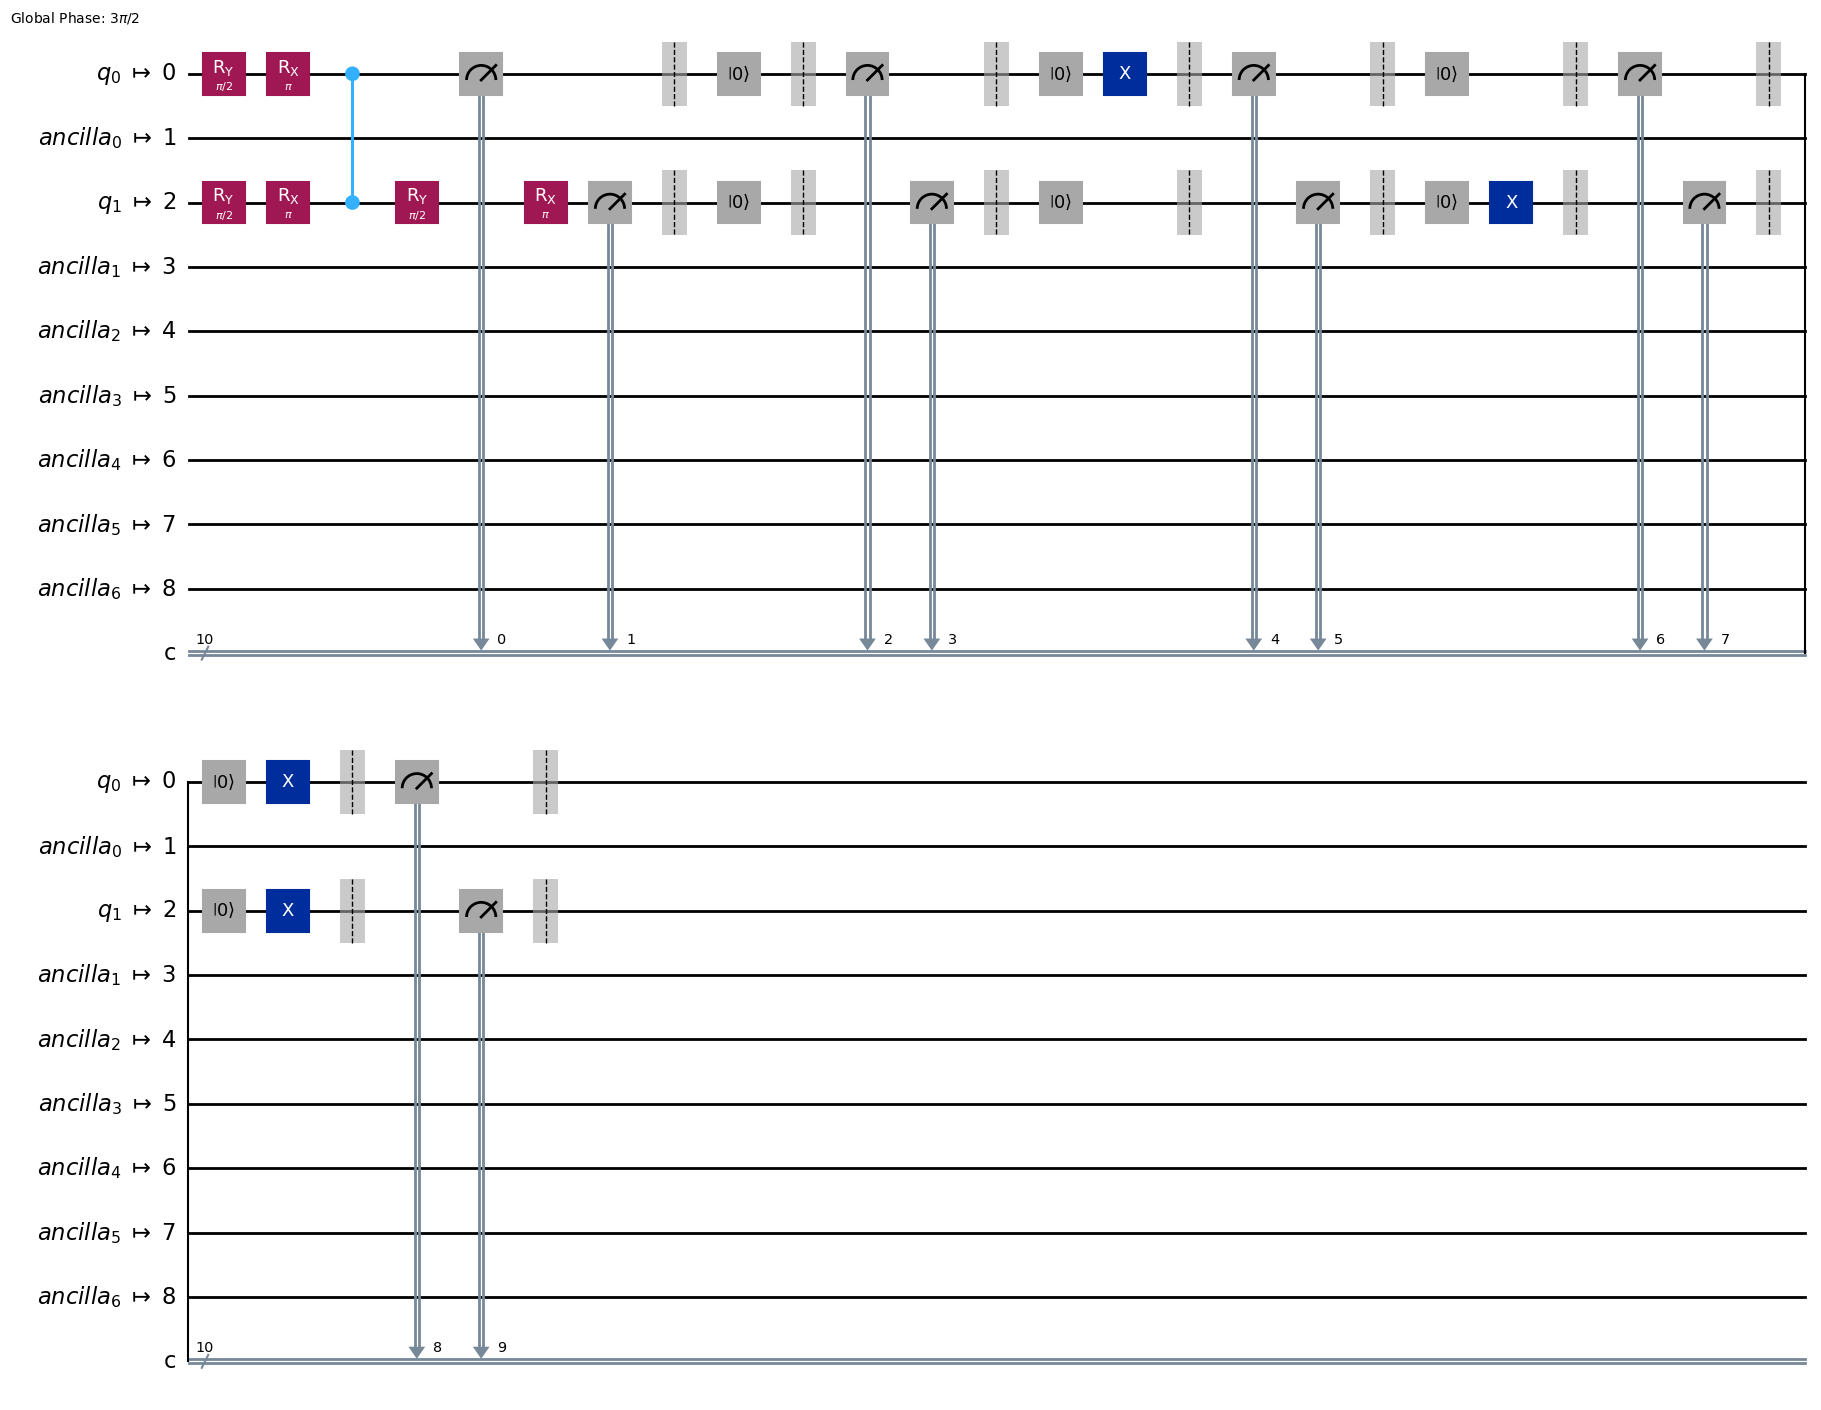

In [19]:
qc_transpiled.draw('mpl')

As is shown in the above figure, the transpiler added additional "ancilla" qubits to the original circuit, which are called so since they are not being used in the algorithm.

In the above circuit, we see the further decomposition of the CNOT gate into single-qubit gates and a single CZ gate. This circuit will be executed by the Tuna backend as it is, without any further internal decomposition.

We now run the transpiled circuit on the Tuna backend,

In [20]:
nr_shots = backend.max_shots
job = backend.run(qc_transpiled, shots=nr_shots, memory = True) # NOTE: memory is set to True in order to return raw data!
result = job.result(timeout = 600)

The following functions are used to separate the shots related to the Bell-state preparation from the shots related to constructing the readout assignment matrix, which is used in post processing to mitigate the effects of readout errors on the raw data.

In [21]:
raw_data_shots, ro_mitigation_shots = split_raw_shots(result, qubit_list)
ro_assignment_matrix = extract_ro_assignment_matrix(ro_mitigation_shots, qubit_list)

raw_data_counts = get_multi_qubit_counts(raw_data_shots, len(qubit_list))
raw_data_probs = get_multi_qubit_prob(raw_data_counts)
ro_corrected_probs = ro_corrected_multi_qubit_prob(raw_data_probs, ro_assignment_matrix, qubit_list)

By plotting the readout assignment matrix, the user can gain valuable information about the state of the readout at the time of executing the quantum circuit on the device,

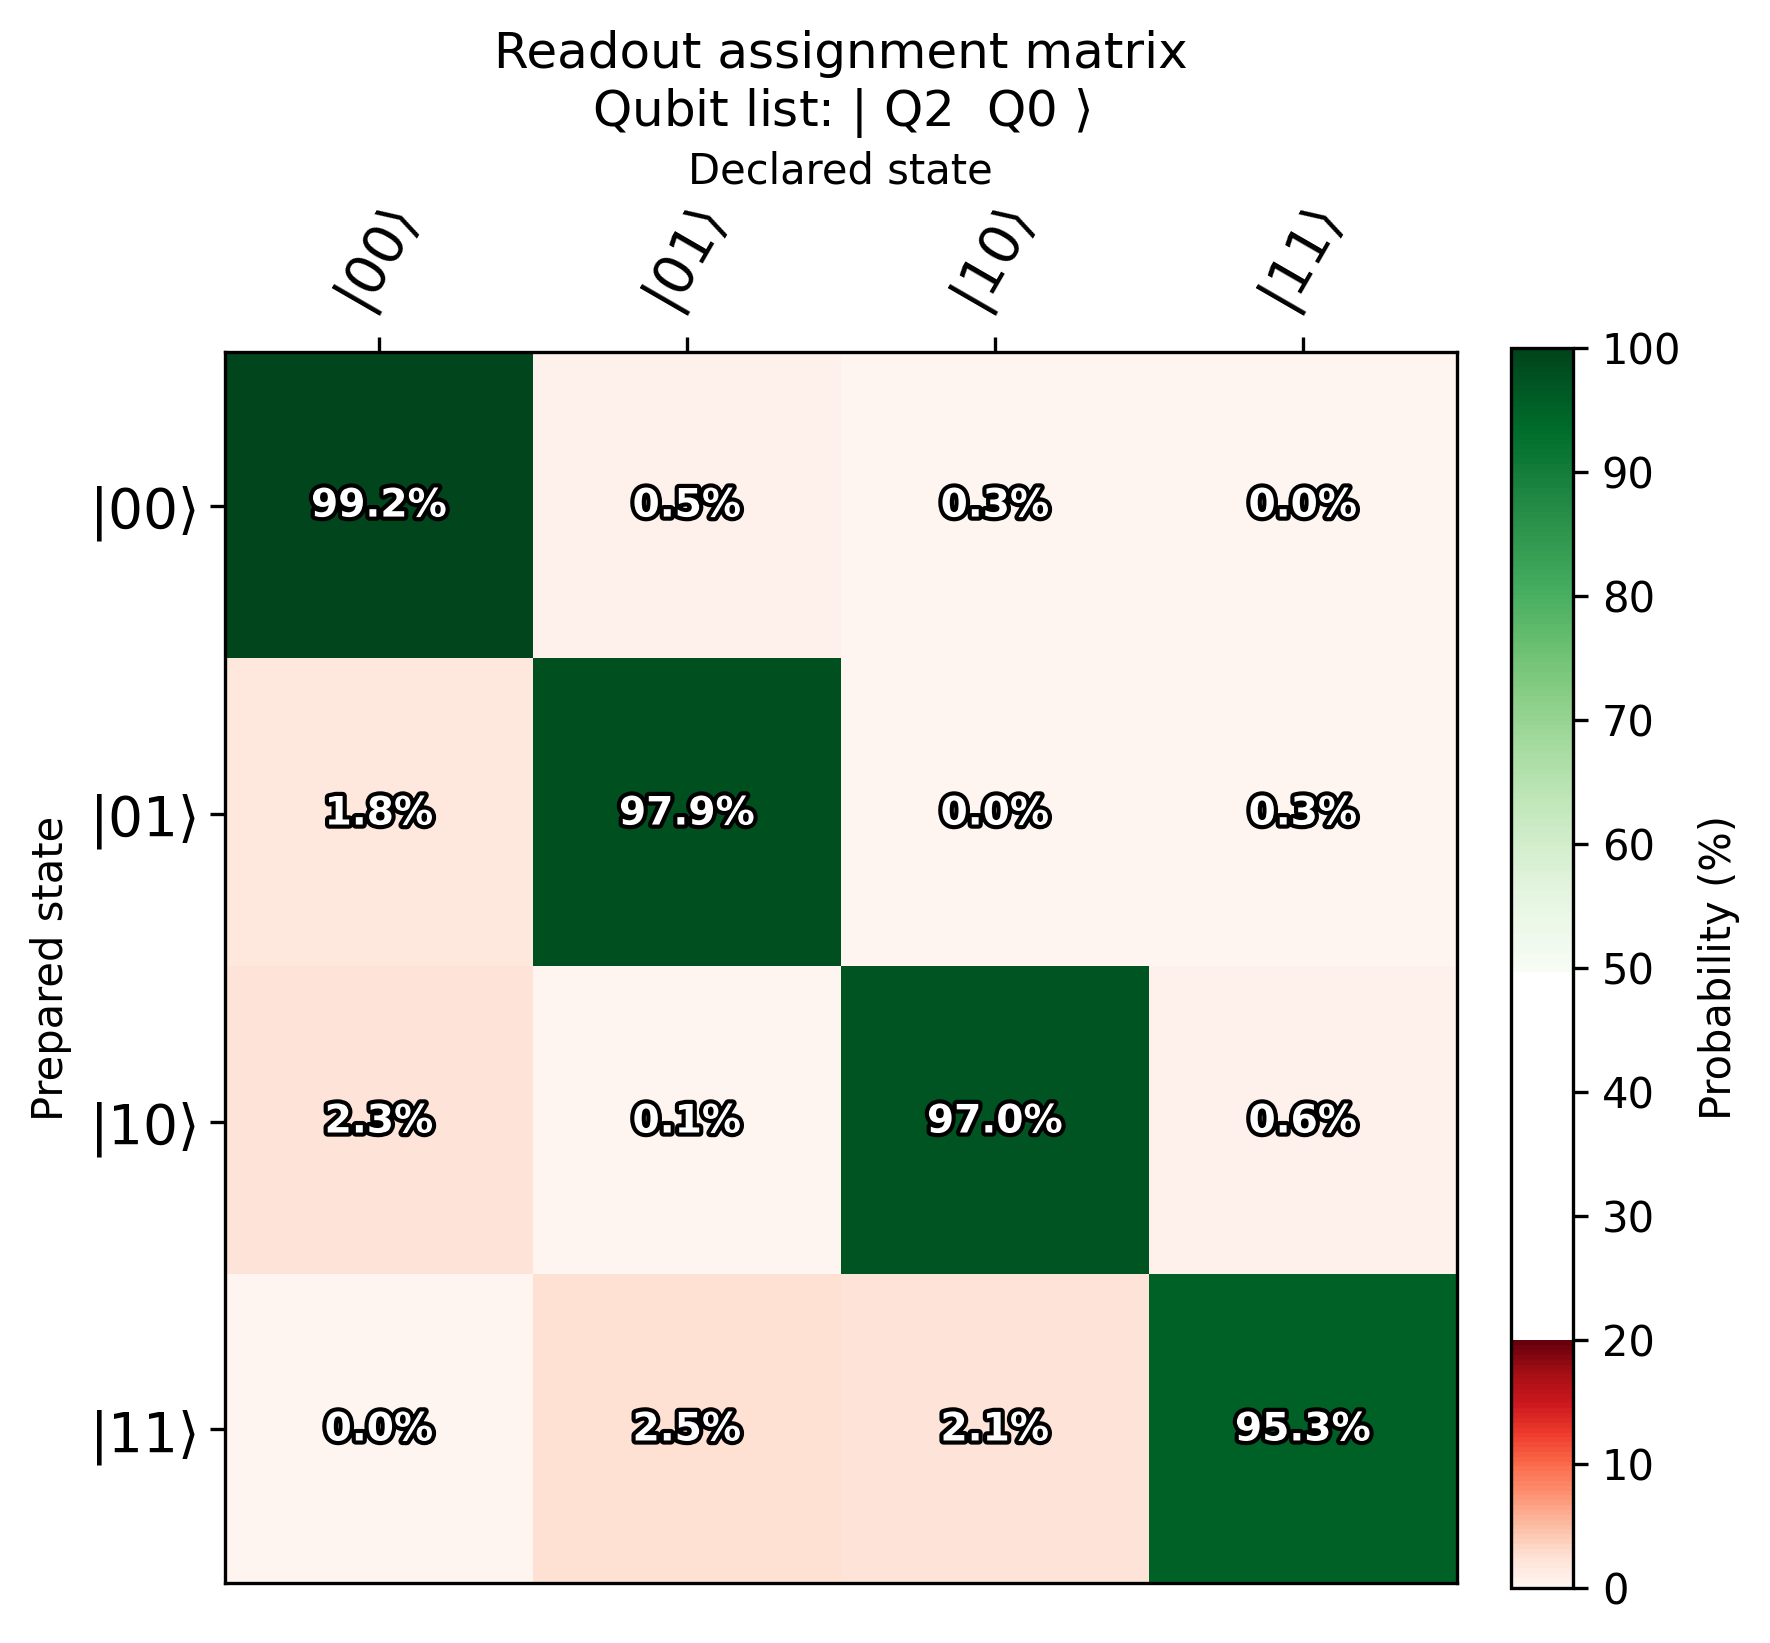

In [22]:
plot_ro_assignment_matrix(ro_assignment_matrix, qubit_list)

Below we plot together the final results of the Bell-state preparation job with and without the use of readout error mitigation, 

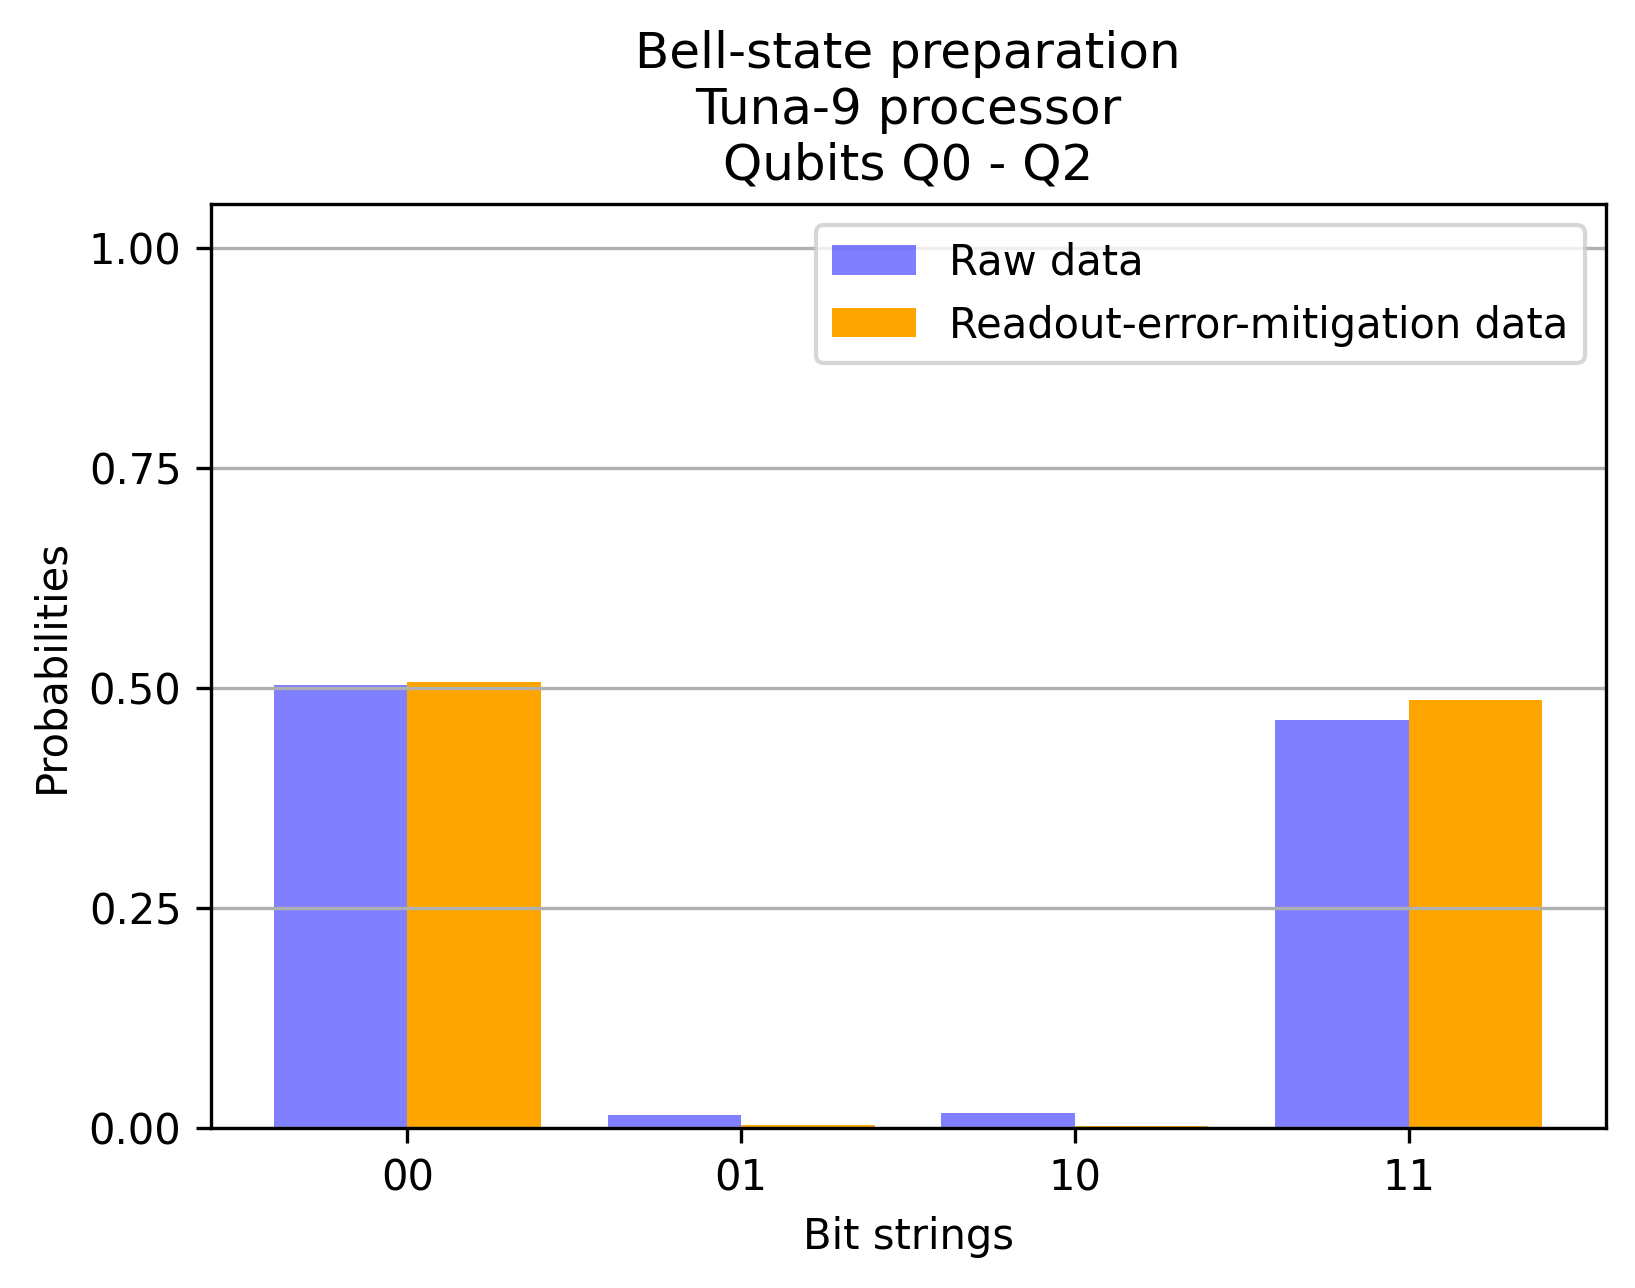

In [23]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

bit_strings = [bit_string for bit_string in raw_data_probs[0]]

ax.bar(bit_strings,
       [raw_data_probs[0][bit_string] for bit_string in raw_data_probs[0]],
       color='blue',
       label='Raw data',
       alpha=0.5, align='edge', width=-0.4)
ax.bar(bit_strings,
       [ro_corrected_probs[0][bit_string] for bit_string in ro_corrected_probs[0]],
       color='orange',
       label='Readout-error-mitigation data',
       align='edge', width=0.4)

ax.set_xlabel("Bit strings")
ax.set_ylabel("Probabilities")
ax.set_title(f"Bell-state preparation\n{backend_name} processor\nQubits Q{qubit_list[0]} - Q{qubit_list[1]}")

ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
ax.set_ylim(0.0, 1.05)
ax.legend()

plt.grid(axis='y')
plt.show()

# 4. Performing a qubit $T_1$ measurement using mid-circuit measurements

In this section, we perform a measurement used widely to estimate the relaxation time $T_1$ of a qubit, using the mid-circuit functionality of the Quantum Inspire SDK. For more information concerning what the qubit relaxation time is or what circuit routines are used to measure it, refer to [A Quantum Engineer's Guide to Superconducting Qubits](https://arxiv.org/abs/1904.06560v5), Section III. B. 2.

We first define the experiment parameters,

In [24]:
qubit_nr = 0 # e.g. the entry "0" is for qubit "Q0"
total_time = 120e-6 # total measurement time in units of [s]
nr_points = 31 # number of measurement points

and then define the experiment circuit. The user does not need to alter the following code,

In [25]:
cycle_time = 20e-9 # cycle time limitation imposed by the Tuna backend internal software
dt = total_time / nr_points
measurement_times = np.linspace(start = 0.0, stop = total_time, num = nr_points)

qc = QuantumCircuit(1, nr_points)
qc.x(qubit_nr) # qubit initialization to the |1> state
qc.measure(qubit = qubit_nr, cbit = 0) # initial measurement at time t=0
for time_idx in range(1, nr_points):
    qc.delay(duration = int((dt / cycle_time)), qarg = qubit_nr) # delay in units of cycle_time
    qc.measure(qubit = qubit_nr, cbit = time_idx)

qc = apply_readout_circuit(qc, [qubit_nr])

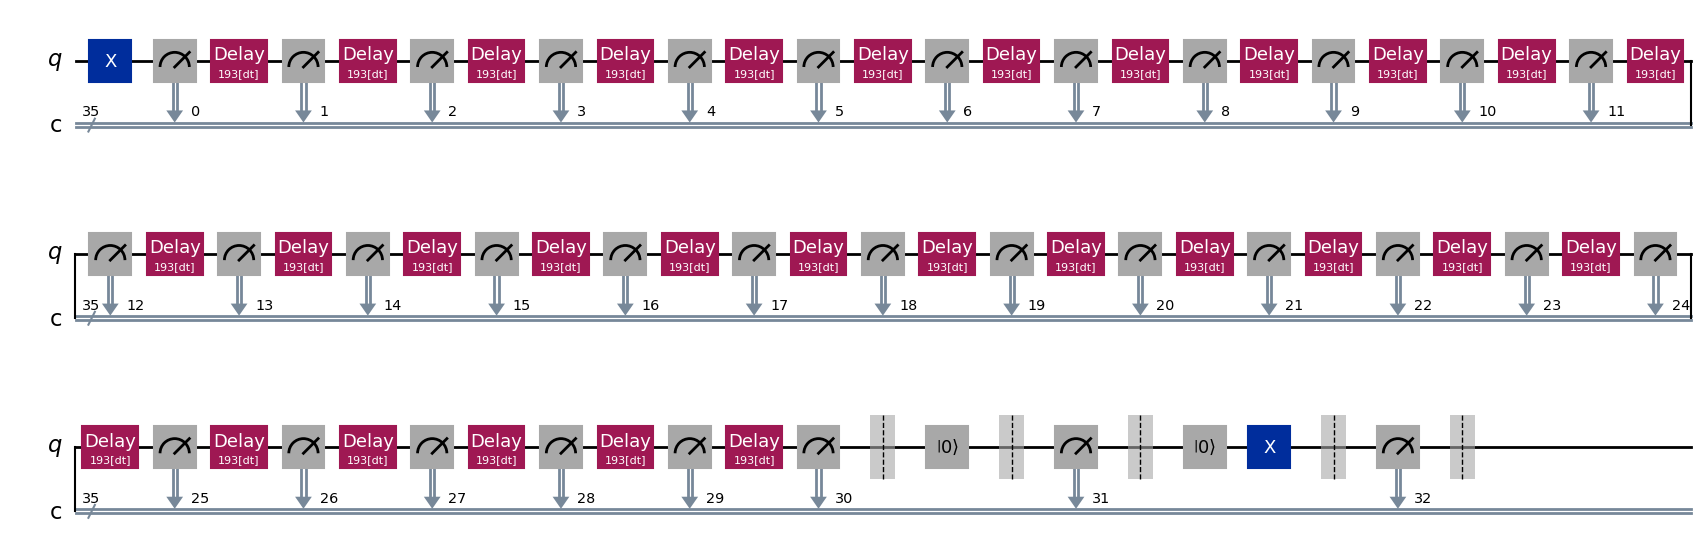

In [26]:
qc.draw('mpl')

Let us now understand the above circuit. A $T_1$ measurement begins with an initial pi pulse ($X$ gate) on the measured qubit, bringing it to its excited state $|1\rangle$, followed by an idle time which we refer to as the "total_time", where we sample the qubit state for a number of "nr_points". An initially excited qubit $|1\rangle$ subsequently relaxes with a high probability to the ground state $|0\rangle$ within the time interval "total_time" defined above.

The "total_time" of the experiment is chosen to be approximately 4 times the qubit relaxation time $T_1$, which was already known at the time of writing this guide, thus we chose $120~\mu s$ as the total duration.

The circuit contains multiple measurement blocks equal to the "nr_points", with an additional two at the very end which are used for the purpose of constructing the readout assignment matrix. These blocks are what we refer to as "mid-circuit measurements".

How do the results of such a measurement look like? The measurement outcome of each measurement block is stored in a separate bit of the classical bit register, which has a total size equal to "nr_points" + 2.

Notice how in the method ".run()" we set "memory = True", in order to return the raw data of the experiment.

In [27]:
nr_shots = 2**11 # NOTE: the user has to be careful with nr_shots using mid-circuit measurements
                 #       if the job fails to be executed, reduce the nr_shots
job = backend.run(qc, shots=nr_shots, memory = True) # NOTE: memory is set to True in order to return raw data!
result = job.result(timeout = 600)

Let us now investigate how the data is organized by first separating the raw data shots from those used to construct the readout assignment matrix,

In [28]:
raw_data_shots, ro_mitigation_shots = split_raw_shots(result, [qubit_nr])

The raw_data_shots list has a total "nr_shots" entries, since we run this circuit for that particular number of shots, and each entry has "nr_points" bits, with each containing the result of each measurement block for the particular circuit run.

The right-most bit of each bit string corresponds to the first measurement block of the quantum circuit, while the left-most bit of each bit string corresponds to the final measurement.

In [29]:
len(raw_data_shots) # size of the raw_data_shots list, equal to nr_shots

2048

In [30]:
len(raw_data_shots[0]) # size of the bit string of each circuit shot, equal to nr_points

31

In [31]:
ro_assignment_matrix = extract_ro_assignment_matrix(ro_mitigation_shots, [qubit_nr])

raw_data_counts = get_multi_qubit_counts(raw_data_shots, len([qubit_nr]))
raw_data_probs = get_multi_qubit_prob(raw_data_counts)
ro_corrected_probs = ro_corrected_multi_qubit_prob(raw_data_probs, ro_assignment_matrix, [qubit_nr])

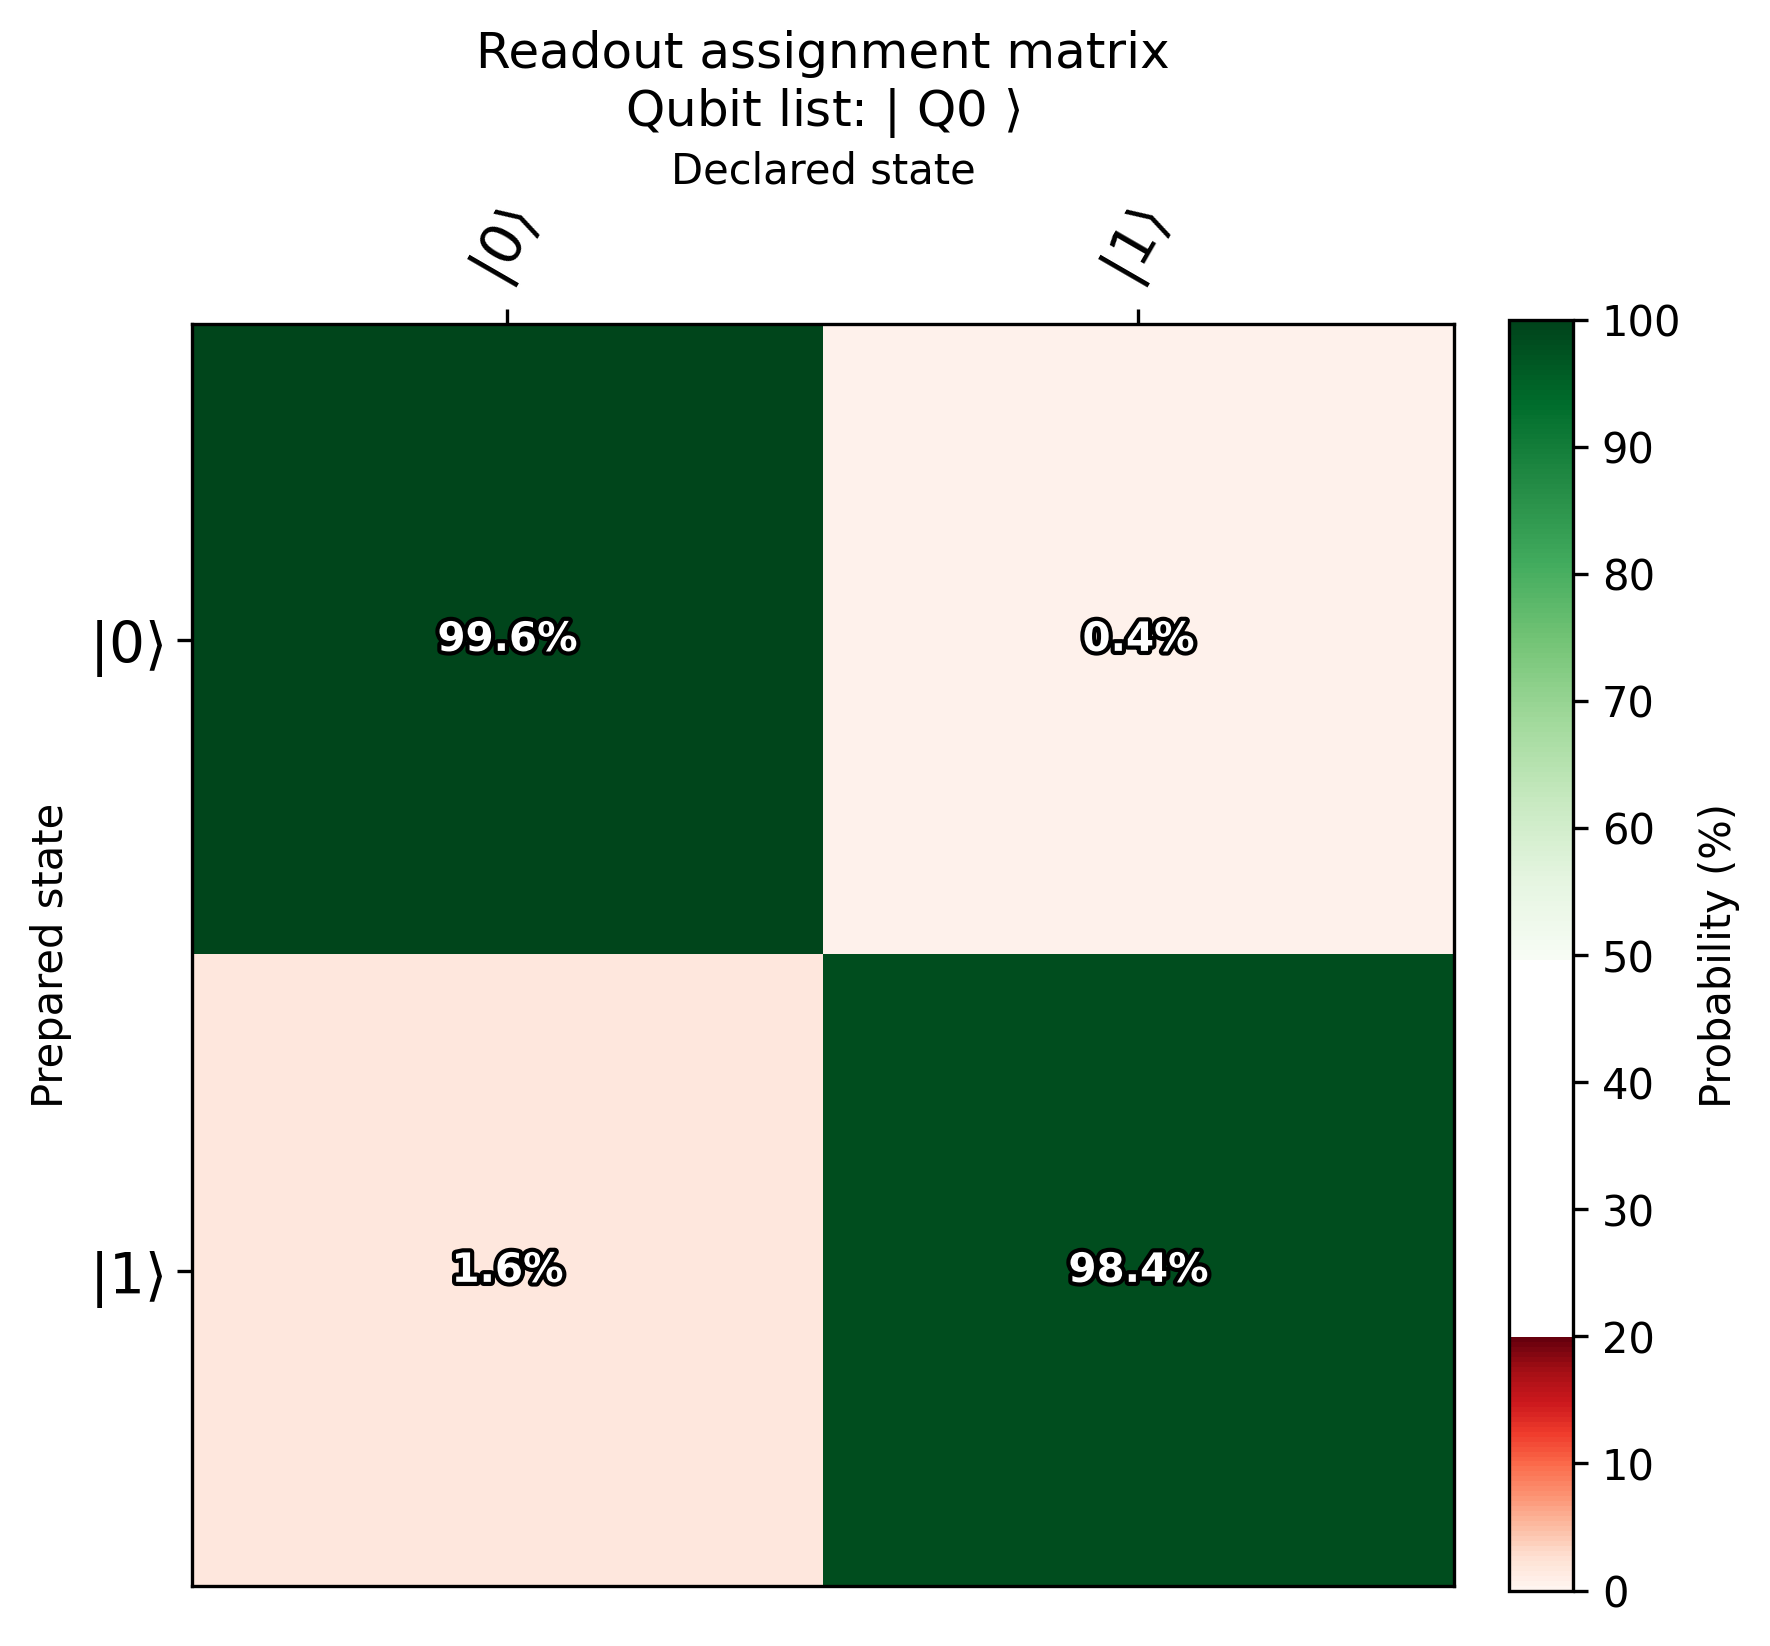

In [32]:
plot_ro_assignment_matrix(ro_assignment_matrix, [qubit_nr])

Finally, we plot the probability of the qubit being in the state $|1\rangle$ for each measurement block, which decreases exponentially with time, eventually reaching the ground state $|0\rangle$. By fitting an exponential curve on the measurement data, we extract the relaxation time $T_1$ of the qubit,

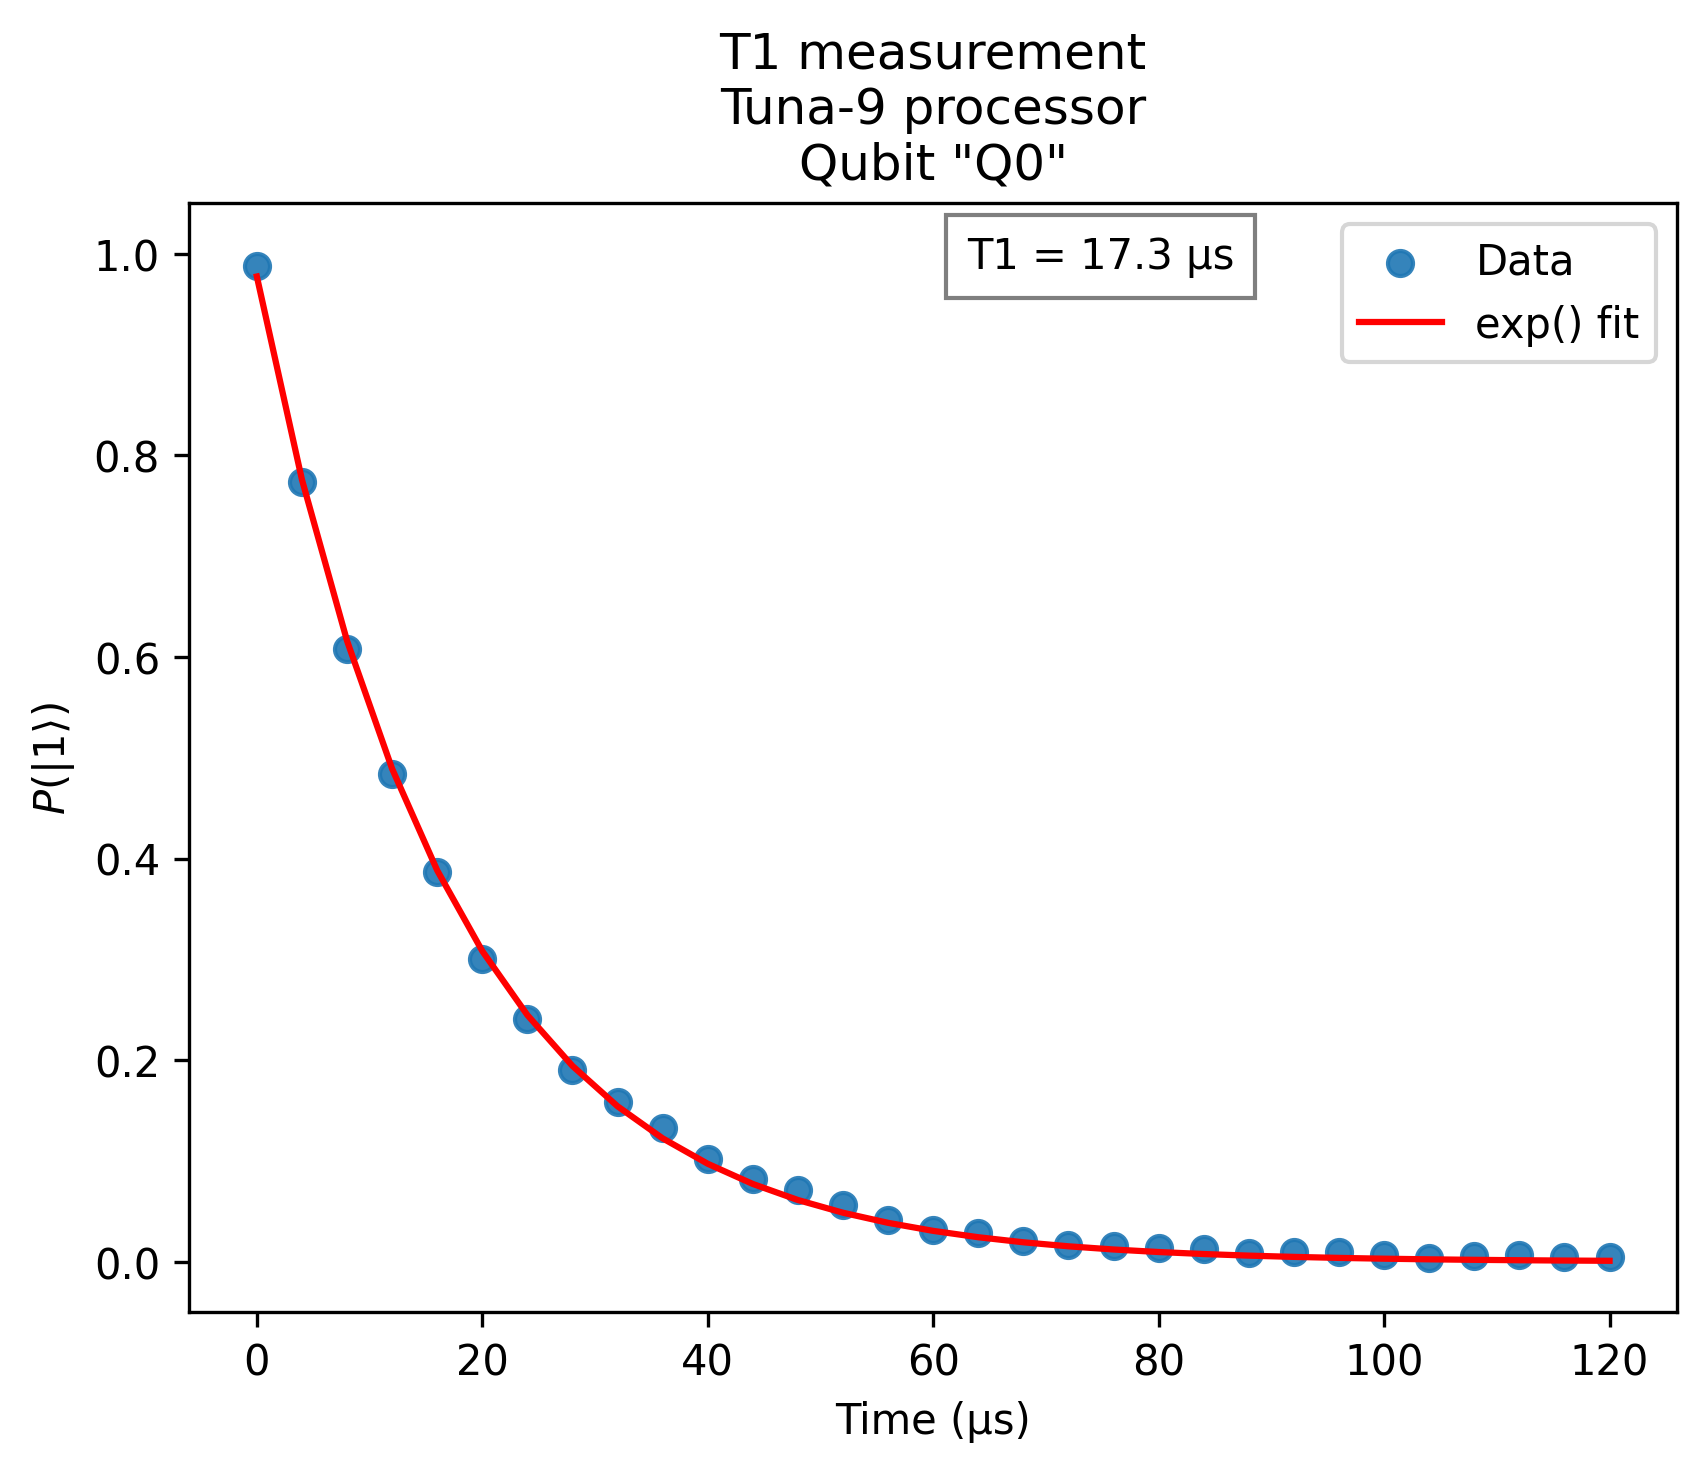

In [33]:
probabilities_excited = [ro_corrected_probs[entry]['1'] for entry in range(nr_points)]

def exponential_func(x, a, b):
    return a * np.exp(b*x)
params, covariance = curve_fit(exponential_func,
                               measurement_times,
                               probabilities_excited)
a_fit, b_fit = params
exponential_fit = exponential_func(measurement_times, a_fit, b_fit)

fig, ax = plt.subplots(dpi=300)
ax.scatter(1e6*measurement_times,
           probabilities_excited,
           label='Data', alpha=0.9)
ax.plot(1e6*measurement_times, exponential_fit, label='exp() fit', color='r')
ax.set_xlabel('Time (μs)')
ax.set_ylabel(r'$P(|1\rangle)$')
ax.set_title(f'T1 measurement\n{backend_name} processor\nQubit "Q{qubit_nr}"')

ax.text(x = 0.5*ax.get_xlim()[1], y = 0.95*ax.get_ylim()[1], s = f'T1 = {- 1e6 * 1 / b_fit:.1f} μs',
        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 5})
ax.set_ylim(-0.05, 1.05)

plt.legend()
plt.show()

# 5. Performing a Rabi oscillation using mid-circuit measurements

In order to perform a [Rabi oscillation](https://en.wikipedia.org/wiki/Rabi_cycle) on a qubit, we need to apply a transversal gate of varied amplitude for different measurement steps. A varied amplitude in our case translates to a varied angle of the applied single-qubit gate.

In a similar fashion to what has already been done in Section 4, we first define the experiment parameters,

In [34]:
qubit_nr = 0 # e.g. the entry "0" is for qubit "Q0"
angle_step = np.pi / 14
total_steps = int(2*np.pi / angle_step) # 2*np.pi is used here for a full revolution

In [35]:
qc = QuantumCircuit(1, total_steps)

for step_idx in range(total_steps):
    qc.delay(6000, qubit_nr) # initialization time for the qubit in units of CC cycles, each cycle worth 20 ns
    qc.rx(step_idx * angle_step, qubit_nr)
    qc.measure(qubit = qubit_nr, cbit = step_idx)

qc = apply_readout_circuit(qc, [qubit_nr])

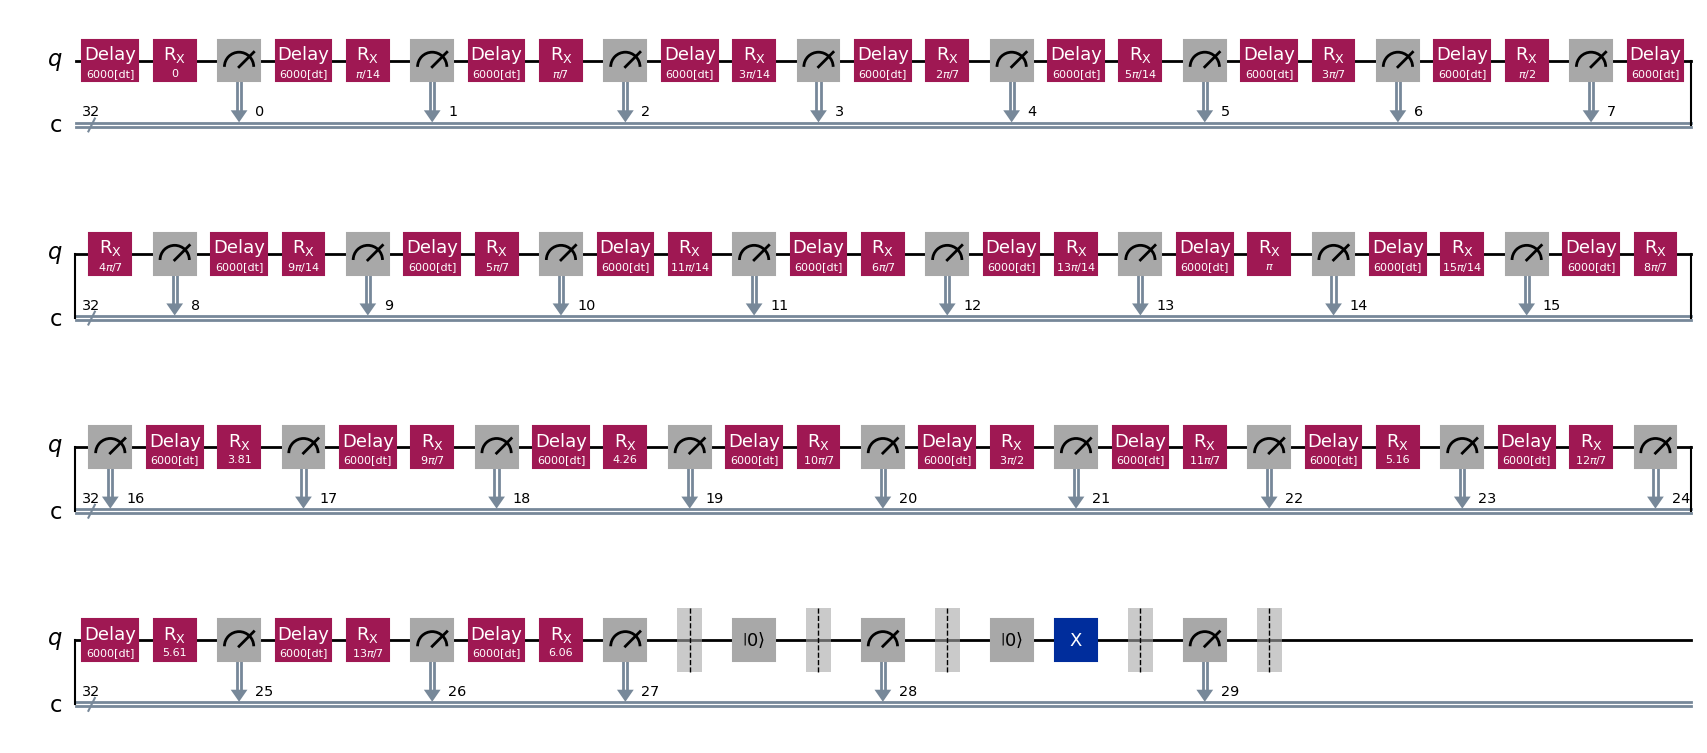

In [36]:
qc.draw('mpl')

Now let us run the above circuit. Notice how nr_shots has been set to $2^{12}$, since we are using multiple measurement blocks. If we request too many shots, we risk having the job fail due to memory limitations of the readout instruments.

In [37]:
nr_shots = 2**12 # NOTE: the user has to be careful with nr_shots using mid-circuit measurements
                #       if the job fails to be executed, reduce the nr_shots
job = backend.run(qc, shots=nr_shots, memory = True)
result = job.result(timeout = 600)

We obtain the readout assignment matrix, as well as the probabilities for each measurement block, and visualize them

In [38]:
raw_data_shots, ro_mitigation_shots = split_raw_shots(result, [qubit_nr])
ro_assignment_matrix = extract_ro_assignment_matrix(ro_mitigation_shots, [qubit_nr])

raw_data_counts = get_multi_qubit_counts(raw_data_shots, len([qubit_nr]))
raw_data_probs = get_multi_qubit_prob(raw_data_counts)
ro_corrected_probs = ro_corrected_multi_qubit_prob(raw_data_probs, ro_assignment_matrix, [qubit_nr])

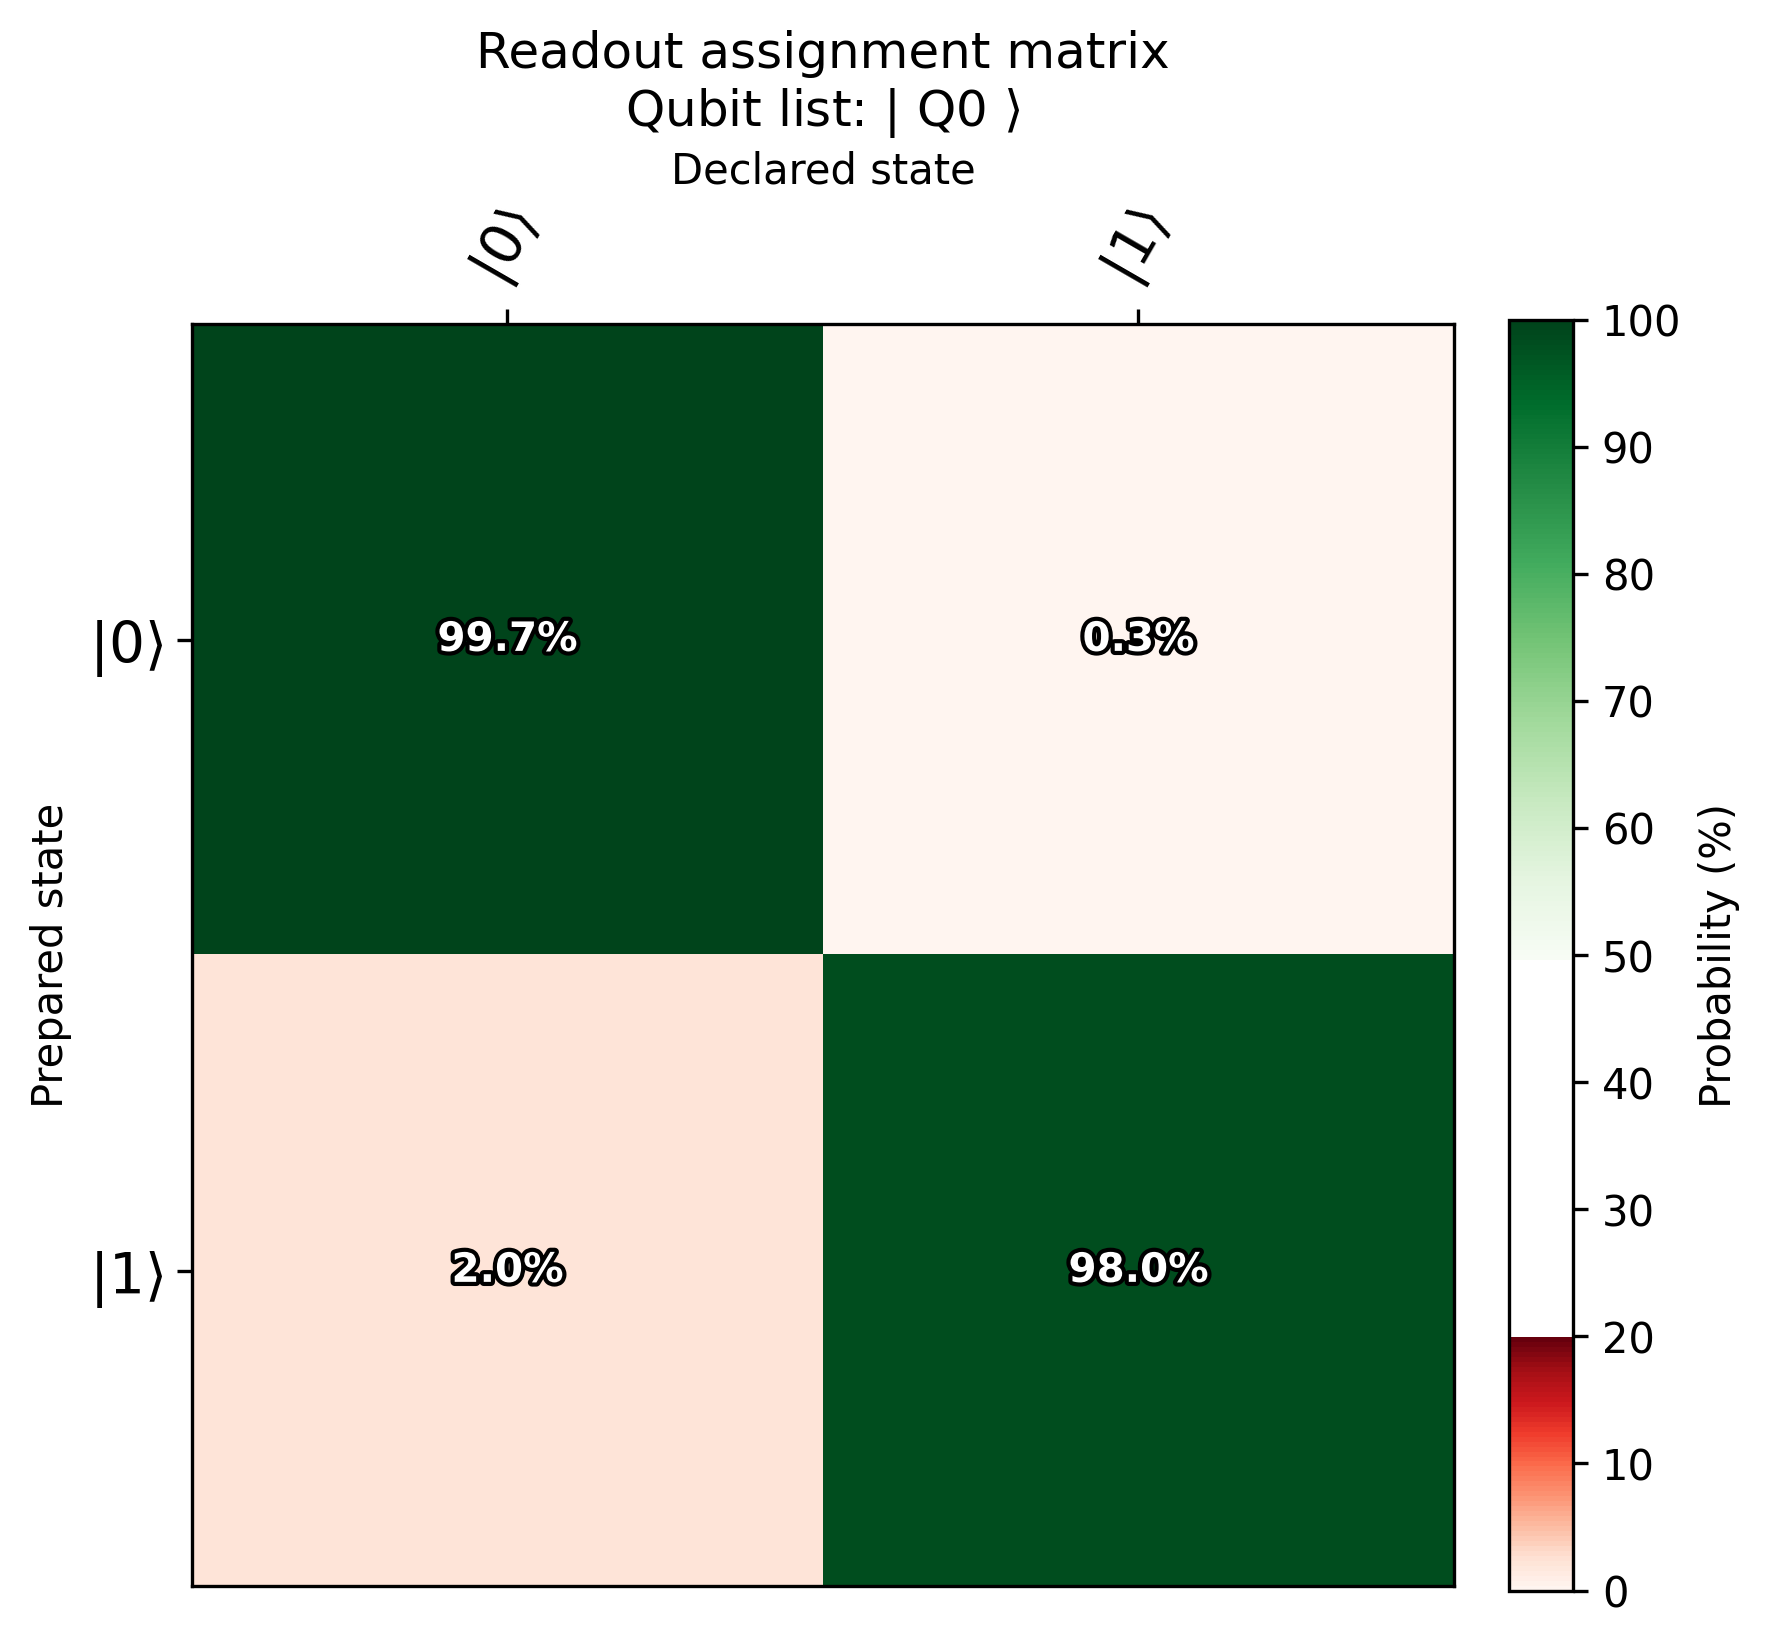

In [39]:
plot_ro_assignment_matrix(ro_assignment_matrix, [qubit_nr])

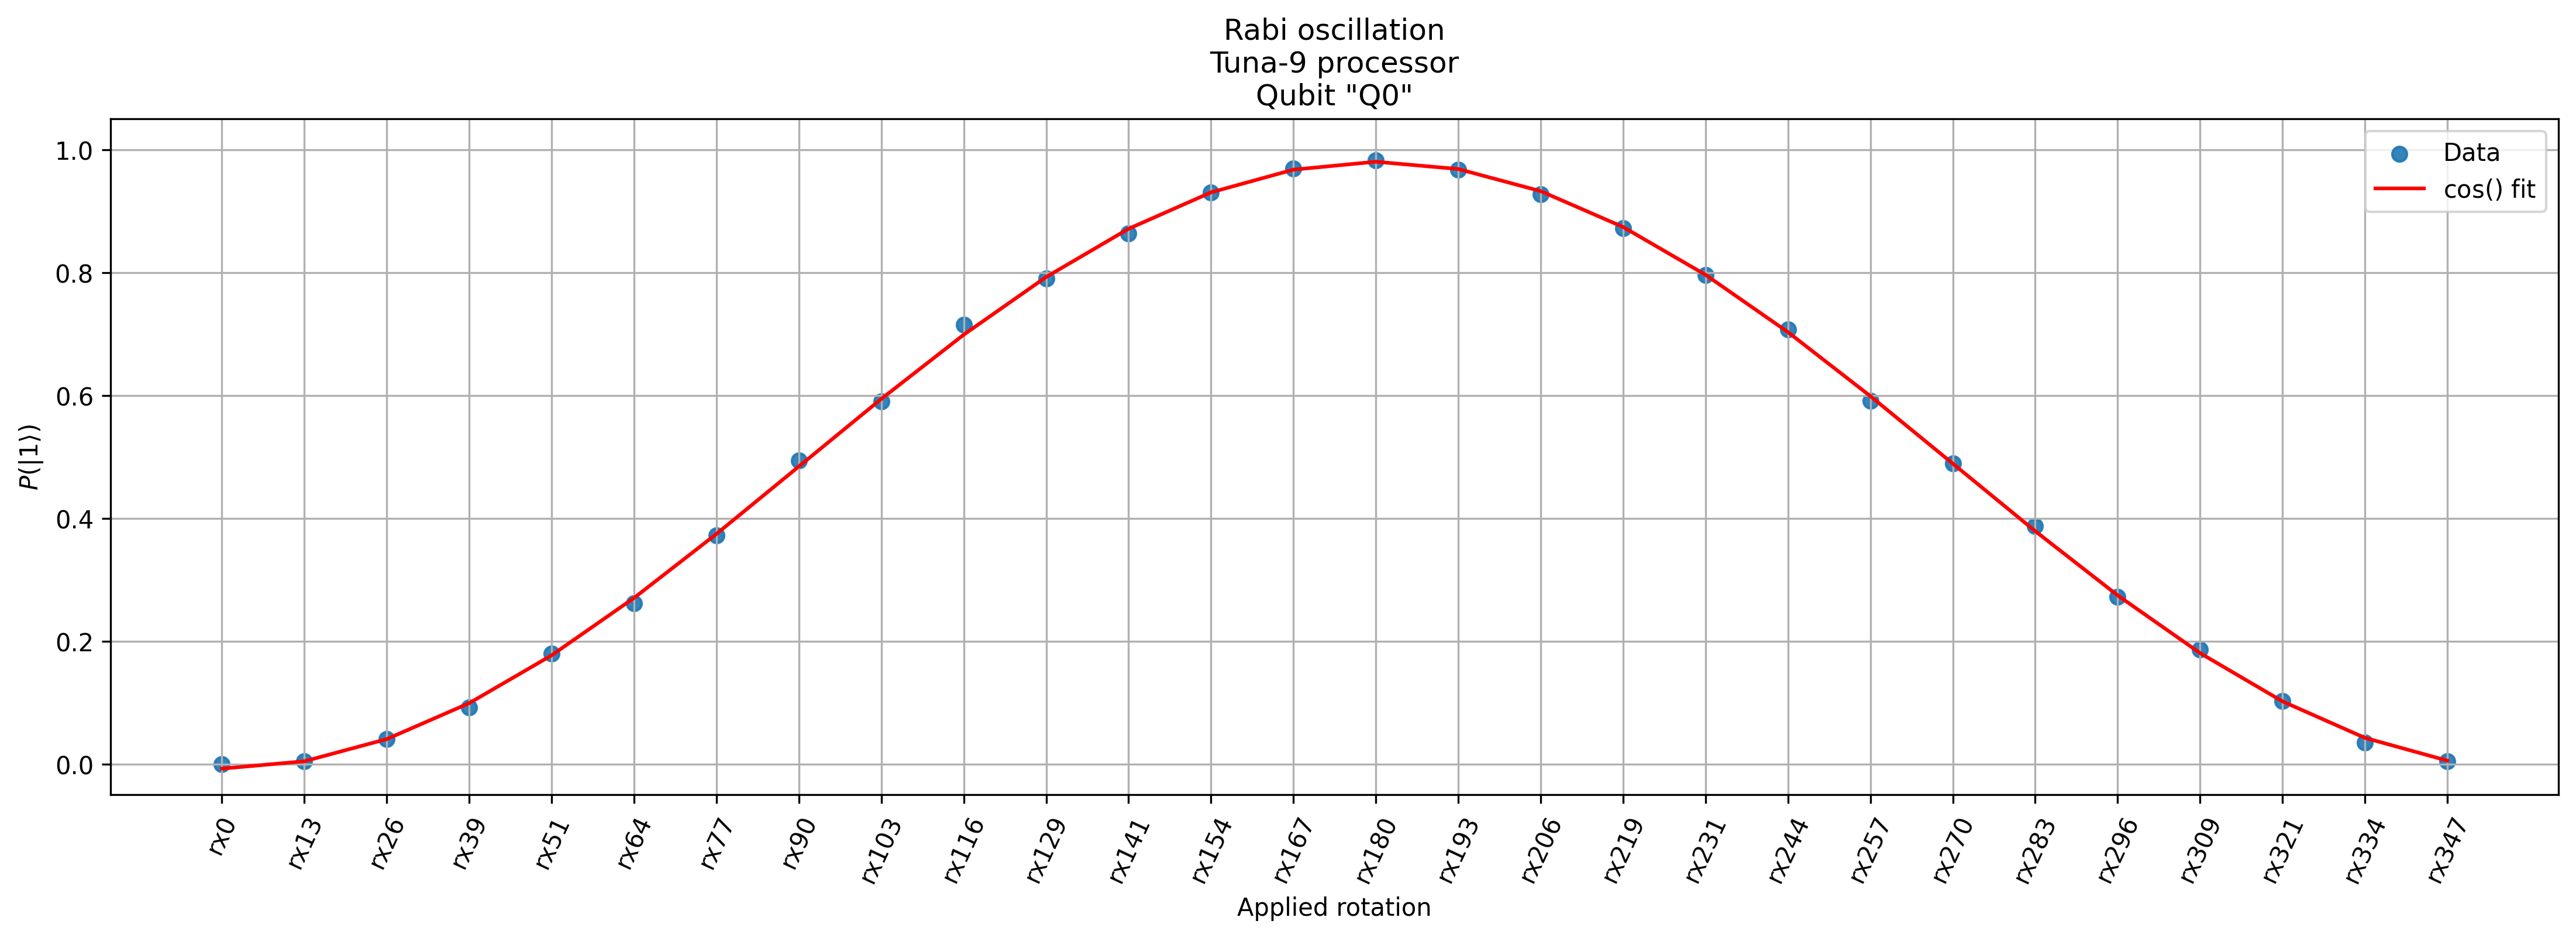

In [40]:
probabilities_excited = [ro_corrected_probs[entry]['1'] for entry in range(total_steps)]

def cos_func(x, a, b, c, d):
    return a * np.cos(2*np.pi*b*x + c) + d
params, covariance = curve_fit(cos_func,
                               np.arange(0, total_steps, 1),
                               probabilities_excited)
a_fit, b_fit, c_fit, d_fit = params
cosine_fit = cos_func(np.arange(0, total_steps, 1), a_fit, b_fit, c_fit, d_fit)

fig, ax = plt.subplots(figsize=(18, 5), dpi=300)
ax.scatter(np.arange(0, total_steps, 1),
           probabilities_excited,
           label='Data', alpha=0.9)
ax.plot(np.arange(0, total_steps, 1), cosine_fit, label=r'$\cos()$' + ' fit', color='r')
ax.set_xlabel('Applied rotation')
ax.set_ylabel(r'$P(|1\rangle)$')
ax.set_title(f'Rabi oscillation\n{backend_name} processor\nQubit "Q{qubit_nr}"')

labels = []
for step_idx in range(total_steps):
    angle_in_degrees = (360 / (2 * np.pi)) * step_idx * angle_step
    step_label = f"rx{round(angle_in_degrees)}"
    labels.append(step_label)
label_locs = np.arange(0, total_steps, 1)
ax.set_xticks(label_locs)
ax.set_xticklabels(labels, rotation=65)
ax.set_ylim(-0.05, 1.05)

plt.grid()
plt.legend()
plt.show()